## Data cleaning
In this noteboook, we will remove noisy data and show the model performance afterwards

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from pycaret.classification import *

In [2]:
df = pd.read_parquet('new_df.parquet')

In [3]:
# remove "deleted" collections, and did_self_destruct
df = df[~df["display_state"].isin([3])]
# 'deleted' iff did_self_destruct 
df.drop(columns=['flags.did_self_destruct'], inplace=True)

# Remove collections with fewer than MIN_HOLDER_THRESHOLD
df = df[df["display_stats.holders"] >= 5]
len(df)

17784

In [4]:
# reorder the labels
df["display_state"].replace(
    [4, 5],
    [3, 4],
    inplace=True,
)

In [5]:
df["display_state"].value_counts(dropna=False)

3    7528
4    4966
2    2247
1    2242
0     801
Name: display_state, dtype: int64

In [6]:
dataset = df[['is_nsfw', 'display_state', 'flags.os_hidden', 'flags.os_is_nsfw', 'flags.code_verified', 'flags.functions_threshold', 'flags.approval_threshold', 'flags.bytecode_threshold', 'flags.is_whitelisted_proxy', 'display_stats.floor_price', 'display_stats.supply', 'display_stats.holders', 'display_stats.one_day_volume', 'display_stats.seven_day_volume', 'display_stats.thirty_day_volume', 'display_stats.total_volume', 'external.telegram_total_member', 'external.has_instagram', 'external.discord_total_member', 'external.has_twitter', 'has_banner_image_url', 'has_description', 'has_collection_image_url', 'has_display_name']]

In [7]:
data = dataset.sample(frac=0.9, random_state=123)
data_unseen = dataset.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (16006, 24)
Unseen Data For Predictions: (1778, 24)


In [8]:
exp_mclf101 = setup(data = data, target = 'display_state', session_id=123, fold_shuffle=True, imputation_type='iterative', 
                    remove_multicollinearity = True)  

,Description,Value
0,session_id,123
1,Target,display_state
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(16006, 24)"
5,Missing Values,False
6,Numeric Features,9
7,Categorical Features,14
8,Ordinal Features,False
9,High Cardinality Features,False


In [9]:
best = compare_models(n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9430,0.9925,0.8776,0.9415,0.9407,0.9184,0.9191,0.3350
lightgbm,Light Gradient Boosting Machine,0.9421,0.9933,0.8817,0.9404,0.9406,0.9174,0.9177,0.3750
gbc,Gradient Boosting Classifier,0.9398,0.9928,0.8767,0.9382,0.9378,0.9141,0.9146,1.4750
et,Extra Trees Classifier,0.9378,0.9900,0.8679,0.9361,0.9355,0.9110,0.9117,0.2860
dt,Decision Tree Classifier,0.9198,0.9474,0.8589,0.9211,0.9201,0.8865,0.8866,0.0210
lda,Linear Discriminant Analysis,0.8668,0.9591,0.7309,0.8636,0.8532,0.8071,0.8108,0.0160
ridge,Ridge Classifier,0.8664,0.0000,0.7095,0.8670,0.8462,0.8051,0.8099,0.0110
knn,K Neighbors Classifier,0.7189,0.8582,0.6064,0.7152,0.7119,0.5893,0.5936,0.0900
ada,Ada Boost Classifier,0.6925,0.7786,0.5740,0.7257,0.6986,0.5782,0.5903,0.1150
qda,Quadratic Discriminant Analysis,0.4416,0.7102,0.5129,0.6452,0.4205,0.3184,0.3727,0.0150


In [10]:
print(best)

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False), LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_fr

In [11]:
evaluate_model(best[0])
evaluate_model(best[1])

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.1
max_depth,-1
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.0
n_estimators,100


In [12]:
md1 = create_model('rf')
md2 = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.9936,0.8786,0.9402,0.9408,0.9174,0.9175
1,0.9456,0.9927,0.8903,0.9447,0.9451,0.9227,0.9227
2,0.9465,0.9932,0.8901,0.9449,0.9450,0.9236,0.9239
3,0.9393,0.9936,0.8694,0.9368,0.9376,0.9136,0.9138
4,0.9438,0.9913,0.8884,0.9423,0.9423,0.9197,0.9201
5,0.9464,0.9952,0.8930,0.9461,0.9454,0.9236,0.9240
6,0.9420,0.9946,0.8888,0.9407,0.9407,0.9172,0.9176
7,0.9339,0.9932,0.8627,0.9315,0.9317,0.9055,0.9061
8,0.9491,0.9932,0.8810,0.9469,0.9471,0.9273,0.9277


In [13]:
tuned_md1 = tune_model(md1)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9358,0.9780,0.8575,0.9329,0.9334,0.9082,0.9086
1,0.9367,0.9770,0.8423,0.9326,0.9332,0.9092,0.9099
2,0.9331,0.9746,0.8335,0.9335,0.9286,0.9041,0.9048
3,0.9358,0.9781,0.8483,0.9319,0.9323,0.9082,0.9088
4,0.9330,0.9783,0.8316,0.9284,0.9285,0.9039,0.9046
5,0.9348,0.9751,0.8425,0.9314,0.9306,0.9062,0.9074
6,0.9295,0.9717,0.8251,0.9260,0.9251,0.8986,0.8995
7,0.9277,0.9708,0.8380,0.9248,0.9231,0.8961,0.8975
8,0.9339,0.9766,0.8430,0.9341,0.9299,0.9051,0.9067


In [14]:
tuned_md2 = tune_model(md2, custom_grid={'learning_rate':[i/200 for i in range(1, 21)]})

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9447,0.9941,0.8840,0.9428,0.9433,0.9211,0.9214
1,0.9420,0.9928,0.8852,0.9409,0.9413,0.9176,0.9176
2,0.9500,0.9937,0.8929,0.9485,0.9485,0.9287,0.9290
3,0.9456,0.9939,0.8874,0.9439,0.9440,0.9224,0.9228
4,0.9429,0.9919,0.8845,0.9413,0.9413,0.9184,0.9188
5,0.9438,0.9949,0.8843,0.9434,0.9422,0.9196,0.9203
6,0.9455,0.9946,0.8880,0.9443,0.9440,0.9222,0.9227
7,0.9402,0.9936,0.8730,0.9381,0.9378,0.9145,0.9151
8,0.9509,0.9937,0.8826,0.9486,0.9488,0.9298,0.9302


In [15]:
tuned_md2

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.055, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


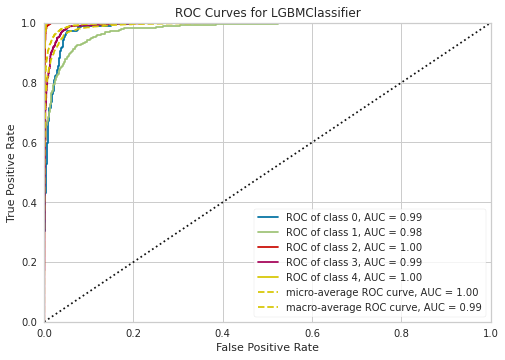

In [16]:
plot_model(tuned_md2, plot = 'auc')

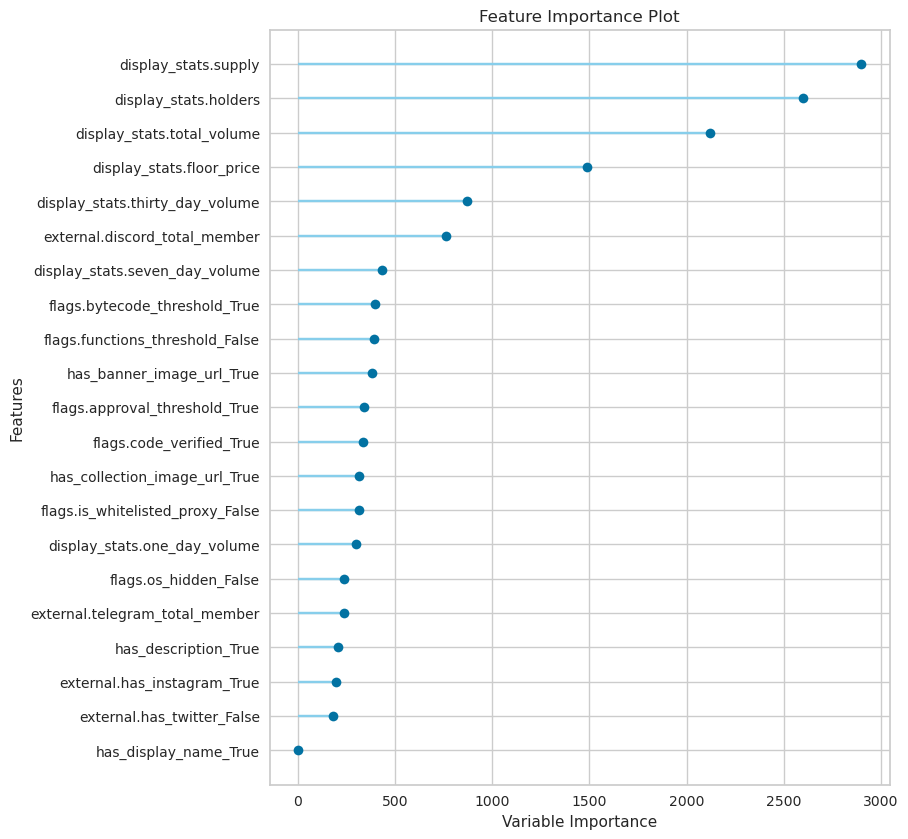

In [17]:
plot_model(tuned_md2, plot = 'feature_all')

In [18]:
evaluate_model(tuned_md2)

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.055
max_depth,-1
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.0
n_estimators,100


In [19]:
predict_model(tuned_md2, encoded_labels=True);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9369,0.9934,0.8828,0.9363,0.9351,0.9111,0.9118


In [20]:
final_md = finalize_model(tuned_md2)

In [21]:
test_predictions = predict_model(final_md, data=data_unseen)
test_predictions.head(100)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9438,0.9945,0.8813,0.9420,0.9422,0.9206,0.9209


,is_nsfw,display_state,flags.os_hidden,flags.os_is_nsfw,flags.code_verified,flags.functions_threshold,flags.approval_threshold,flags.bytecode_threshold,flags.is_whitelisted_proxy,display_stats.floor_price,...,external.telegram_total_member,external.has_instagram,external.discord_total_member,external.has_twitter,has_banner_image_url,has_description,has_collection_image_url,has_display_name,Label,Score
0,False,3,False,False,True,True,True,True,False,0.0000,...,0,False,0,True,True,True,True,True,3,0.9932
1,False,3,False,False,True,True,True,True,False,0.0002,...,0,False,0,True,True,True,True,True,3,0.9986
2,False,3,False,False,True,True,True,True,False,0.0065,...,0,True,276,True,True,True,True,True,3,0.9926
3,False,4,False,False,False,False,False,True,False,0.0000,...,0,False,0,False,False,False,False,True,4,0.9992
4,False,2,False,False,True,True,False,False,False,0.0000,...,0,False,0,False,False,False,False,True,2,0.9927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,3,False,False,True,True,True,True,False,0.0390,...,0,False,0,True,True,True,True,True,3,0.9502
96,False,0,False,False,True,False,True,True,False,0.0055,...,0,False,0,True,True,True,True,True,0,0.6936
97,False,3,False,False,True,True,True,True,False,0.0990,...,0,True,1283,False,True,True,True,True,3,0.9410
98,False,4,False,False,False,False,False,True,False,0.0000,...,0,False,0,False,False,False,False,True,4,0.9993


In [22]:
save_model(final_md,'Final Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='display_state',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type='gbdt',
                                                              class_weight=None,
                                                              colsample...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                    

In [24]:
saved_final_md = load_model('final_model_preprocessed')

Transformation Pipeline and Model Successfully Loaded


In [ ]:
new_prediction = predict_model(saved_final_md, data=data_unseen)